<a href="https://colab.research.google.com/github/karu-bee/SIGNATE_Practice/blob/main/SGN_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import time
import os
from matplotlib import pyplot as plt
import random
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

%matplotlib inline
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 
#画像とラベルを読み込む
data_dir = '/content/drive/MyDrive/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5,
                                             shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([5, 3, 224, 224])
torch.float32


In [ ]:
#ネットワークの定義
net = models.vgg16(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
net

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#ネットワークのパラメータを凍結
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#最適化関数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
num_epochs = 15

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/15], Loss: 1.4375, val_loss: 3.3970, val_acc: 0.5000, lr：0.01
Epoch [2/15], Loss: 1.9231, val_loss: 0.1962, val_acc: 0.8500, lr：0.01
Epoch [3/15], Loss: 2.2330, val_loss: 0.3387, val_acc: 0.9000, lr：0.01
Epoch [4/15], Loss: 2.6502, val_loss: 1.3519, val_acc: 0.7500, lr：0.01
Epoch [5/15], Loss: 3.5762, val_loss: 1.8459, val_acc: 0.7000, lr：0.01
Epoch [6/15], Loss: 2.2184, val_loss: 1.2906, val_acc: 0.7000, lr：0.01
Epoch [7/15], Loss: 3.0534, val_loss: 2.8437, val_acc: 0.6000, lr：0.01
Epoch [8/15], Loss: 3.2001, val_loss: 2.5815, val_acc: 0.6500, lr：0.01
Epoch [9/15], Loss: 3.1298, val_loss: 1.4721, val_acc: 0.8000, lr：0.01
Epoch [10/15], Loss: 2.1474, val_loss: 0.9165, val_acc: 0.7500, lr：0.01
Epoch [11/15], Loss: 2.4656, val_loss: 0.6043, val_acc: 0.8000, lr：0.001
Epoch [12/15], Loss: 2.1596, val_loss: 0.7014, val_acc: 0.9000, lr：0.001
Epoch [13/15], Loss: 1.5318, val_loss: 0.7926, val_acc: 0.9000, lr：0.001
Epoch [14/15], Loss: 2.3479, val_loss: 0.5529, val_acc: 0.8500, lr：0.0

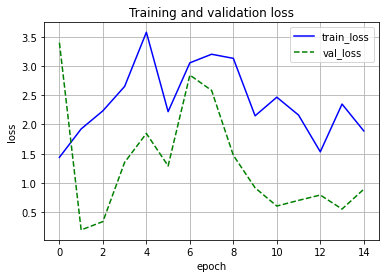

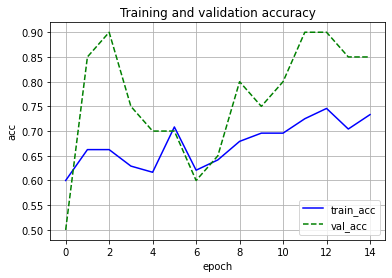

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [ ]:
# ネットワークを保存する
torch.save(net.state_dict(), 'net.ckpt')

In [ ]:
# ネットワークを読み込む
net.load_state_dict(torch.load('net.ckpt'))

<All keys matched successfully>

In [ ]:
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 3, 224, 224).to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 
    print(f"test_acc={test_acc}, total={total}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


精度: 85.0 %
test_acc=17, total=20


In [ ]:
# 提出データ作成
TEST_DATADIR = '/content/drive/MyDrive/test/'

test_dataset = datasets.ImageFolder(TEST_DATADIR, data_transforms['val'])
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
labels = np.empty(0)
probs = torch.empty((0,2)).to(device)
with torch.no_grad():
    for idx, (data,label) in enumerate(testloader):
        x = data.to(device)
        y = net(x)
        labels = np.concatenate((labels, label))
        probs = torch.cat((probs, y), axis=0)

probs = probs.cpu().numpy()
preds = np.argmax(probs, axis=1)

In [ ]:
import pandas as pd
import datetime
filenames = [os.path.basename(p[0]) for p in test_dataset.imgs]
#pred_ft = np.logical_not(preds_tf).astype(np.int)
pred_ft = np.logical_not(preds).astype(np.int)
df = pd.DataFrame(zip(filenames, pred_ft), columns=["filename", "regular0_defect1"])
df = df.sort_values("filename")
display(df)
df.to_csv(f"submit_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index=False, header=False)
#df.to_csv(f"submit_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}_{SEED}.tsv", index=False, header=False, sep="\t")

,filename,regular0_defect1
0,1009937.jpeg,0
1,109996.jpeg,1
2,119892.jpeg,1
3,129893.jpeg,0
4,139981.jpeg,1
...,...,...
95,969983.jpeg,1
96,979891.jpeg,0
97,989921.jpeg,0
98,99851.jpeg,0
